In [1]:
import os
import numpy as np
import pandas as pd
from functools import partial

from datetime import datetime, timedelta
from scipy.optimize import least_squares
from tqdm.notebook import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed

import matplotlib.pyplot as plt

In [2]:
PLOT_DATA = "../data/interim/plot_info_for_climatena.csv"
locations = (
    pd.read_csv(PLOT_DATA)
    .rename({"ID1": "PLOT_ID", "el": "ELEV"}, axis=1)
    .set_index("PLOT_ID")
)
locations.columns = [col.upper() for col in locations.columns]
locations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12156 entries, 60101550679 to 530907572668
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID2     0 non-null      float64
 1   LAT     12156 non-null  float64
 2   LON     12156 non-null  float64
 3   ELEV    12156 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 474.8 KB


In [3]:
CLOUD_DATA = "../data/interim/MODIS_monthly_cloud_fraction.csv"
cloud = pd.read_csv(CLOUD_DATA)
cloud["PERIOD"] = pd.to_datetime(cloud["PERIOD"]).dt.to_period("M")
cloud = cloud.set_index(["PLOT_ID", "PERIOD"])
cloud.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3172716 entries, (60101550679.0, Period('2000-02', 'M')) to (530906597320.0, Period('2021-12', 'M'))
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   CLOUDS  float64
dtypes: float64(1)
memory usage: 36.7 MB


In [4]:
SUN_DATA = "../data/interim/monthly_irradiance_for_plots.csv"
sun = pd.read_csv(SUN_DATA)
sun["PERIOD"] = pd.to_datetime(sun["PERIOD"]).dt.to_period("M")
sun = sun.set_index(["PLOT_ID", "PERIOD"])
sun.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4667904 entries, (60101572041, Period('1990-01', 'M')) to (530907572668, Period('2021-12', 'M'))
Data columns (total 8 columns):
 #   Column              Dtype  
---  ------              -----  
 0   POA_GLOBAL          float64
 1   POA_DIRECT          float64
 2   POA_DIFFUSE         float64
 3   POA_SKY_DIFFUSE     float64
 4   POA_GROUND_DIFFUSE  float64
 5   CLEARSKY_GHI        float64
 6   CLEARSKY_DNI        float64
 7   CLEARSKY_DHI        float64
dtypes: float64(8)
memory usage: 303.1 MB


In [5]:
CLIM_DATA = "../data/interim/climatena_1990-2020_monthly_long.csv"
clim = pd.read_csv(CLIM_DATA)
clim["PERIOD"] = pd.to_datetime(clim["PERIOD"]).dt.to_period("M")
clim = clim.set_index(["PLOT_ID", "PERIOD"])["RH"]
clim.info()

<class 'pandas.core.series.Series'>
MultiIndex: 4522032 entries, (60101550679, Period('1990-01', 'M')) to (530907572668, Period('2020-12', 'M'))
Series name: RH
Non-Null Count    Dtype
--------------    -----
4522032 non-null  int64
dtypes: int64(1)
memory usage: 52.1 MB


In [6]:
obs = pd.merge(clim, cloud, how="inner", left_index=True, right_index=True).merge(
    sun, how="inner", left_index=True, right_index=True
)
obs.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3039000 entries, (60101550679, Period('2000-02', 'M')) to (530907572668, Period('2020-12', 'M'))
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   RH                  int64  
 1   CLOUDS              float64
 2   POA_GLOBAL          float64
 3   POA_DIRECT          float64
 4   POA_DIFFUSE         float64
 5   POA_SKY_DIFFUSE     float64
 6   POA_GROUND_DIFFUSE  float64
 7   CLEARSKY_GHI        float64
 8   CLEARSKY_DNI        float64
 9   CLEARSKY_DHI        float64
dtypes: float64(9), int64(1)
memory usage: 243.8 MB


In [7]:
def pred_cloud_cover(
    monthly_intercepts,
    slope_rh,
    slope_elev,
    month_of_year,
    relative_humidity,
    elevation,
    clip_clouds=False,
):
    cloud_cover = (
        monthly_intercepts[month_of_year - 1]
        + slope_rh * relative_humidity
        + slope_elev * elevation
    )
    if clip_clouds:
        cloud_cover = np.clip(cloud_cover, 0, 1)
    return cloud_cover


def cloud_cover_correction(clearsky_ghi, cloud_cover, offset=0.35):
    ghi = clearsky_ghi * (offset + (1 - offset) * (1 - cloud_cover))
    return ghi


def pred_cloudy_ghi(
    monthly_intercepts,
    slope_rh,
    slope_elev,
    month_of_year,
    relative_humidity,
    elevation,
    clearsky_ghi,
    clip_clouds=False,
):
    cloud_cover = pred_cloud_cover(
        monthly_intercepts,
        slope_rh,
        slope_elev,
        month_of_year,
        relative_humidity,
        elevation,
        clip_clouds=clip_clouds,
    )
    return cloud_cover_correction(clearsky_ghi, cloud_cover)


def cloudy_ghi_resid(
    coefs,
    month_of_year,
    relative_humidity,
    elevation,
    cloud_obs,
    clearsky_ghi,
    clip_clouds=False,
):
    (
        jan,
        feb,
        mar,
        apr,
        may,
        jun,
        jul,
        aug,
        sep,
        octo,
        nov,
        dec,
        slope_rh,
        slope_elev,
    ) = coefs
    monthly_intercepts = np.array(
        [jan, feb, mar, apr, may, jun, jul, aug, sep, octo, nov, dec]
    )
    pred = pred_cloudy_ghi(
        monthly_intercepts,
        slope_rh,
        slope_elev,
        month_of_year,
        relative_humidity,
        elevation,
        clearsky_ghi,
        clip_clouds=clip_clouds,
    )
    obs = cloud_cover_correction(clearsky_ghi, cloud_obs)
    return pred - obs


def fit_linear_cloud(plot_id):
    res = least_squares(
        cloudy_ghi_resid,
        x0=(
            -0.5,
            -0.5,
            -0.5,
            -0.5,
            -0.5,
            -0.5,  # monthly coefs
            -0.5,
            -0.5,
            -0.5,
            -0.5,
            -0.5,
            -0.5,  # monthly coefs
            0.05,
            0.0,
        ),  # rh and elev
        args=(
            obs.loc[plot_id].index.month.values.astype(int),
            obs.loc[plot_id, "RH"].values,
            locations.loc[plot_id, "ELEV"],
            obs.loc[plot_id, "CLOUDS"].values,
            obs.loc[plot_id, "CLEARSKY_GHI"].values,
        ),
        bounds=(
            (
                -np.inf,
                -np.inf,
                -np.inf,
                -np.inf,
                -np.inf,
                -np.inf,
                -np.inf,
                -np.inf,
                -np.inf,
                -np.inf,
                -np.inf,
                -np.inf,
                0.01,
                0,
            ),
            (
                np.inf,
                np.inf,
                np.inf,
                np.inf,
                np.inf,
                np.inf,
                np.inf,
                np.inf,
                np.inf,
                np.inf,
                np.inf,
                np.inf,
                0.05,
                np.inf,
            ),
        ),
        xtol=1e-15,
    )
    return plot_id, res

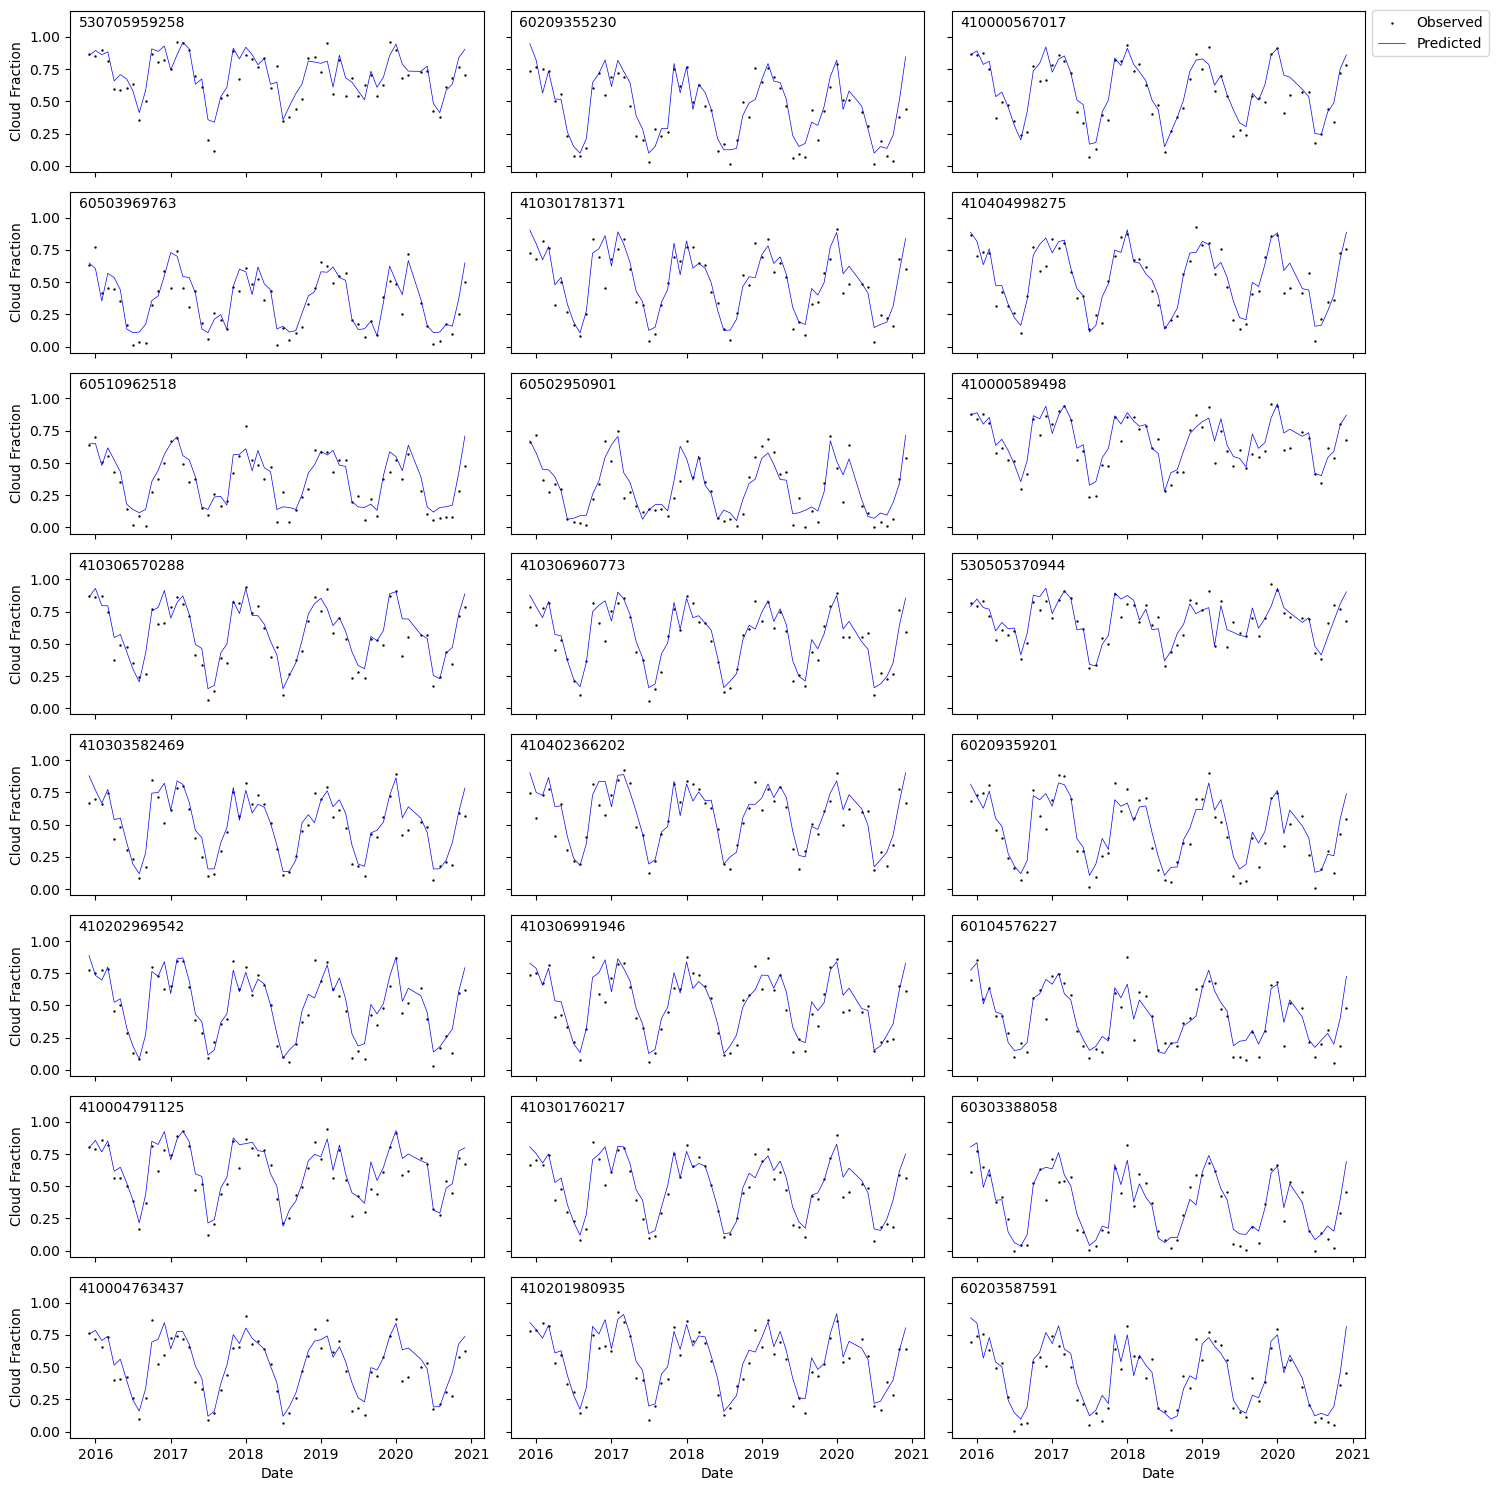

In [8]:
fig, axs = plt.subplots(8, 3, figsize=(15, 15), sharex=True, sharey=True)
plots = np.random.choice(obs.index.get_level_values(0), 24)

for i, plot in enumerate(plots):
    _, res = fit_linear_cloud(plot)
    coefs = res.x
    cost = res.cost

    cloud_obs = obs.loc[plot, "CLOUDS"]
    cloud_pred = pred_cloud_cover(
        coefs[:12],
        coefs[12],
        coefs[13],
        month_of_year=obs.loc[plot].index.month,
        relative_humidity=obs.loc[plot, "RH"].values,
        elevation=locations.loc[plot, "ELEV"],
        clip_clouds=True,
    )
    dates = obs.loc[plot].index.to_timestamp()

    axs.ravel()[i].scatter(
        dates[-60:], cloud_obs[-60:], color="black", s=0.5, label="Observed"
    )
    axs.ravel()[i].plot(
        dates[-60:], cloud_pred[-60:], color="blue", lw=0.5, label="Predicted"
    )
    # axs.ravel()[i].set_title(plot)
    axs.ravel()[i].text(0.02, 0.90, plot, transform=axs.ravel()[i].transAxes)

for ax in axs[-1, :]:
    ax.set_xlabel("Date")
for ax in axs[:, 0]:
    ax.set_ylabel("Cloud Fraction")
    ax.set_ylim(None, 1.20)
axs[0, -1].legend(bbox_to_anchor=(1.0, 1.05))
plt.tight_layout()
plt.savefig(
    "../reports/figures/example_cloud_predictions_timeseries.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

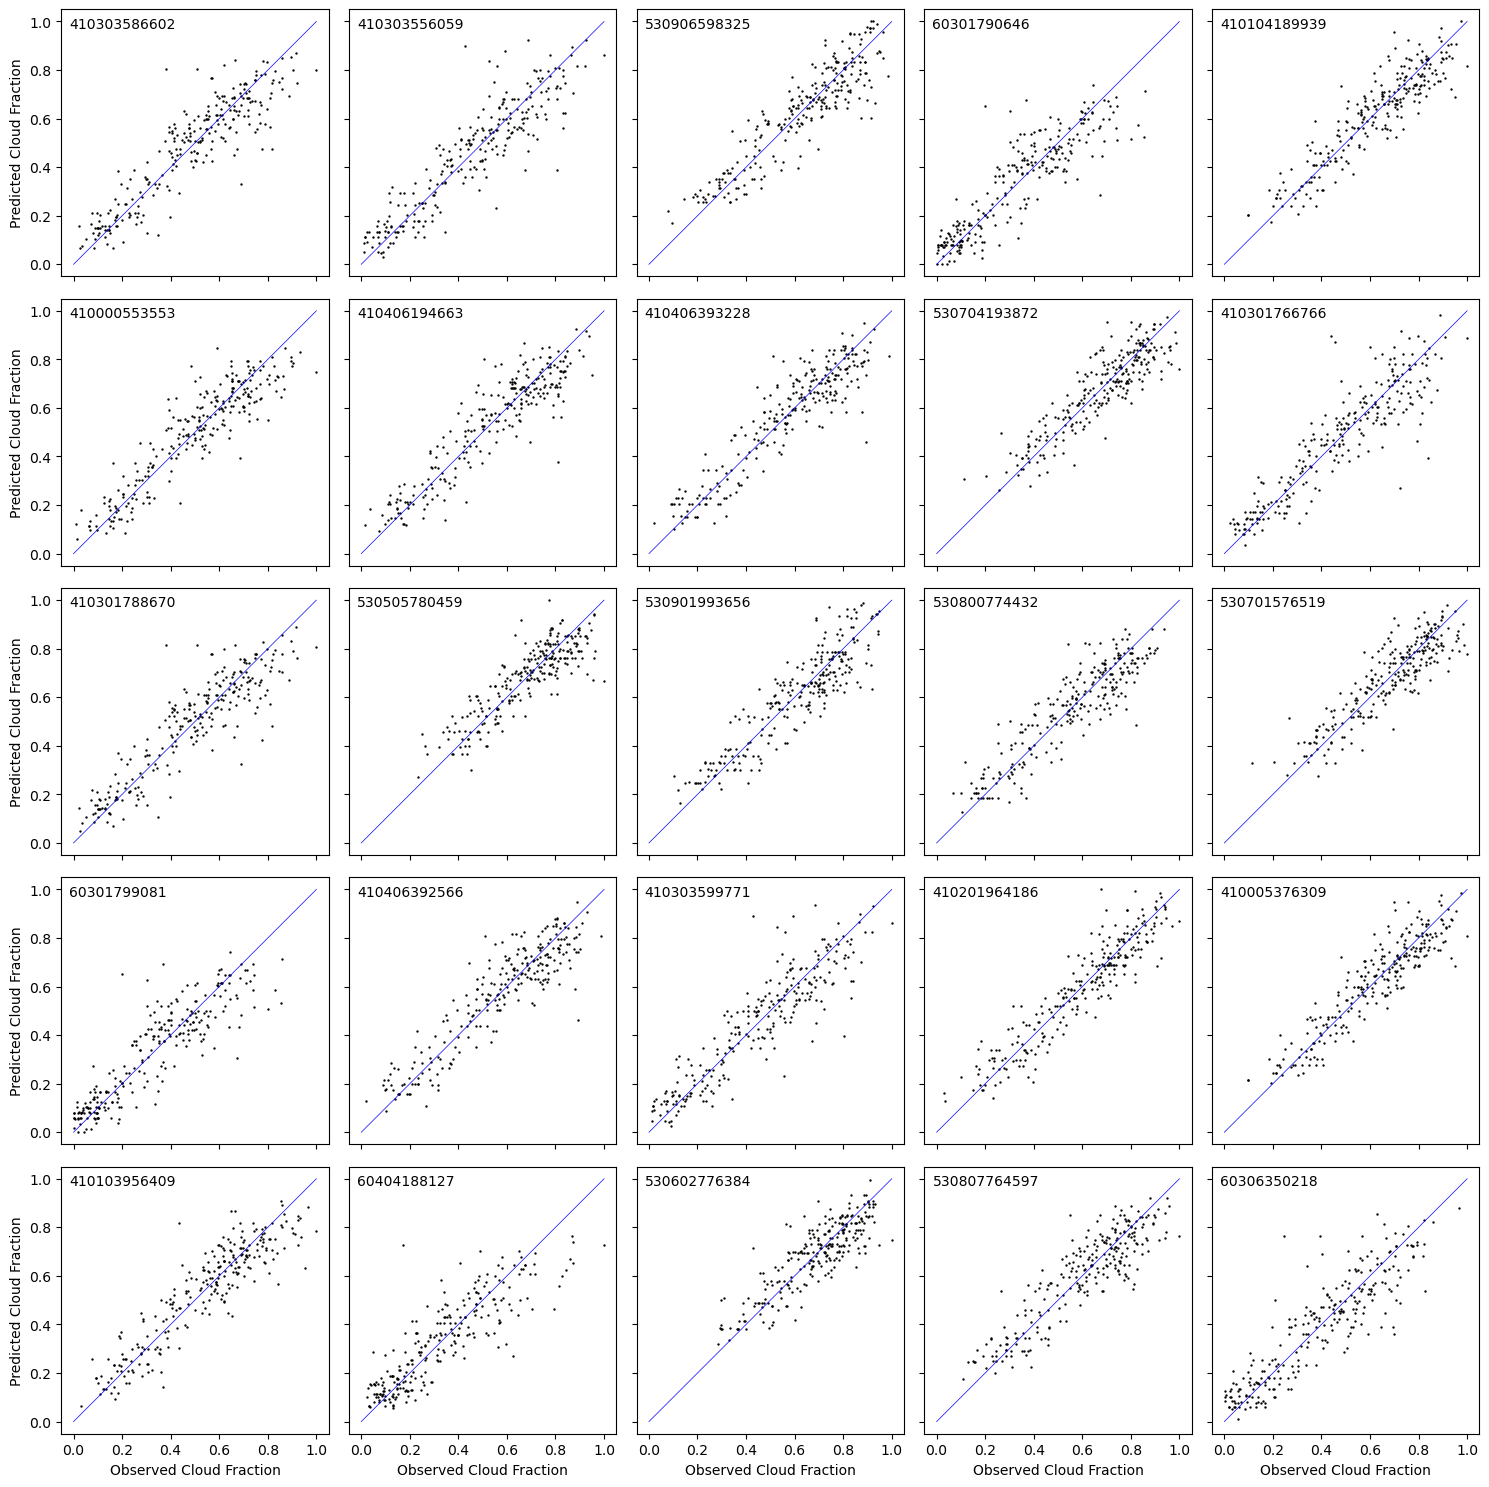

In [9]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15), sharex=True, sharey=True)
plots = np.random.choice(obs.index.get_level_values(0), 25)
for i, plot in enumerate(plots):
    _, res = fit_linear_cloud(plot)
    coefs = res.x
    cloud_obs = obs.loc[plot, "CLOUDS"]
    cloud_pred = pred_cloud_cover(
        coefs[:12],
        coefs[12],
        coefs[13],
        month_of_year=obs.loc[plot].index.month,
        relative_humidity=obs.loc[plot, "RH"].values,
        elevation=locations.loc[plot, "ELEV"],
        clip_clouds=True,
    )
    axs.ravel()[i].scatter(cloud_obs, cloud_pred, color="black", s=0.5)
    axs.ravel()[i].set_aspect("equal")
    axs.ravel()[i].plot((0, 1), (0, 1), color="blue", lw=0.5)
    axs.ravel()[i].text(0.03, 0.93, plot, transform=axs.ravel()[i].transAxes)

for ax in axs[-1, :]:
    ax.set_xlabel("Observed Cloud Fraction")
for ax in axs[:, 0]:
    ax.set_ylabel("Predicted Cloud Fraction")

plt.tight_layout()
plt.savefig(
    "../reports/figures/observed_predicted_cloud_fraction.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

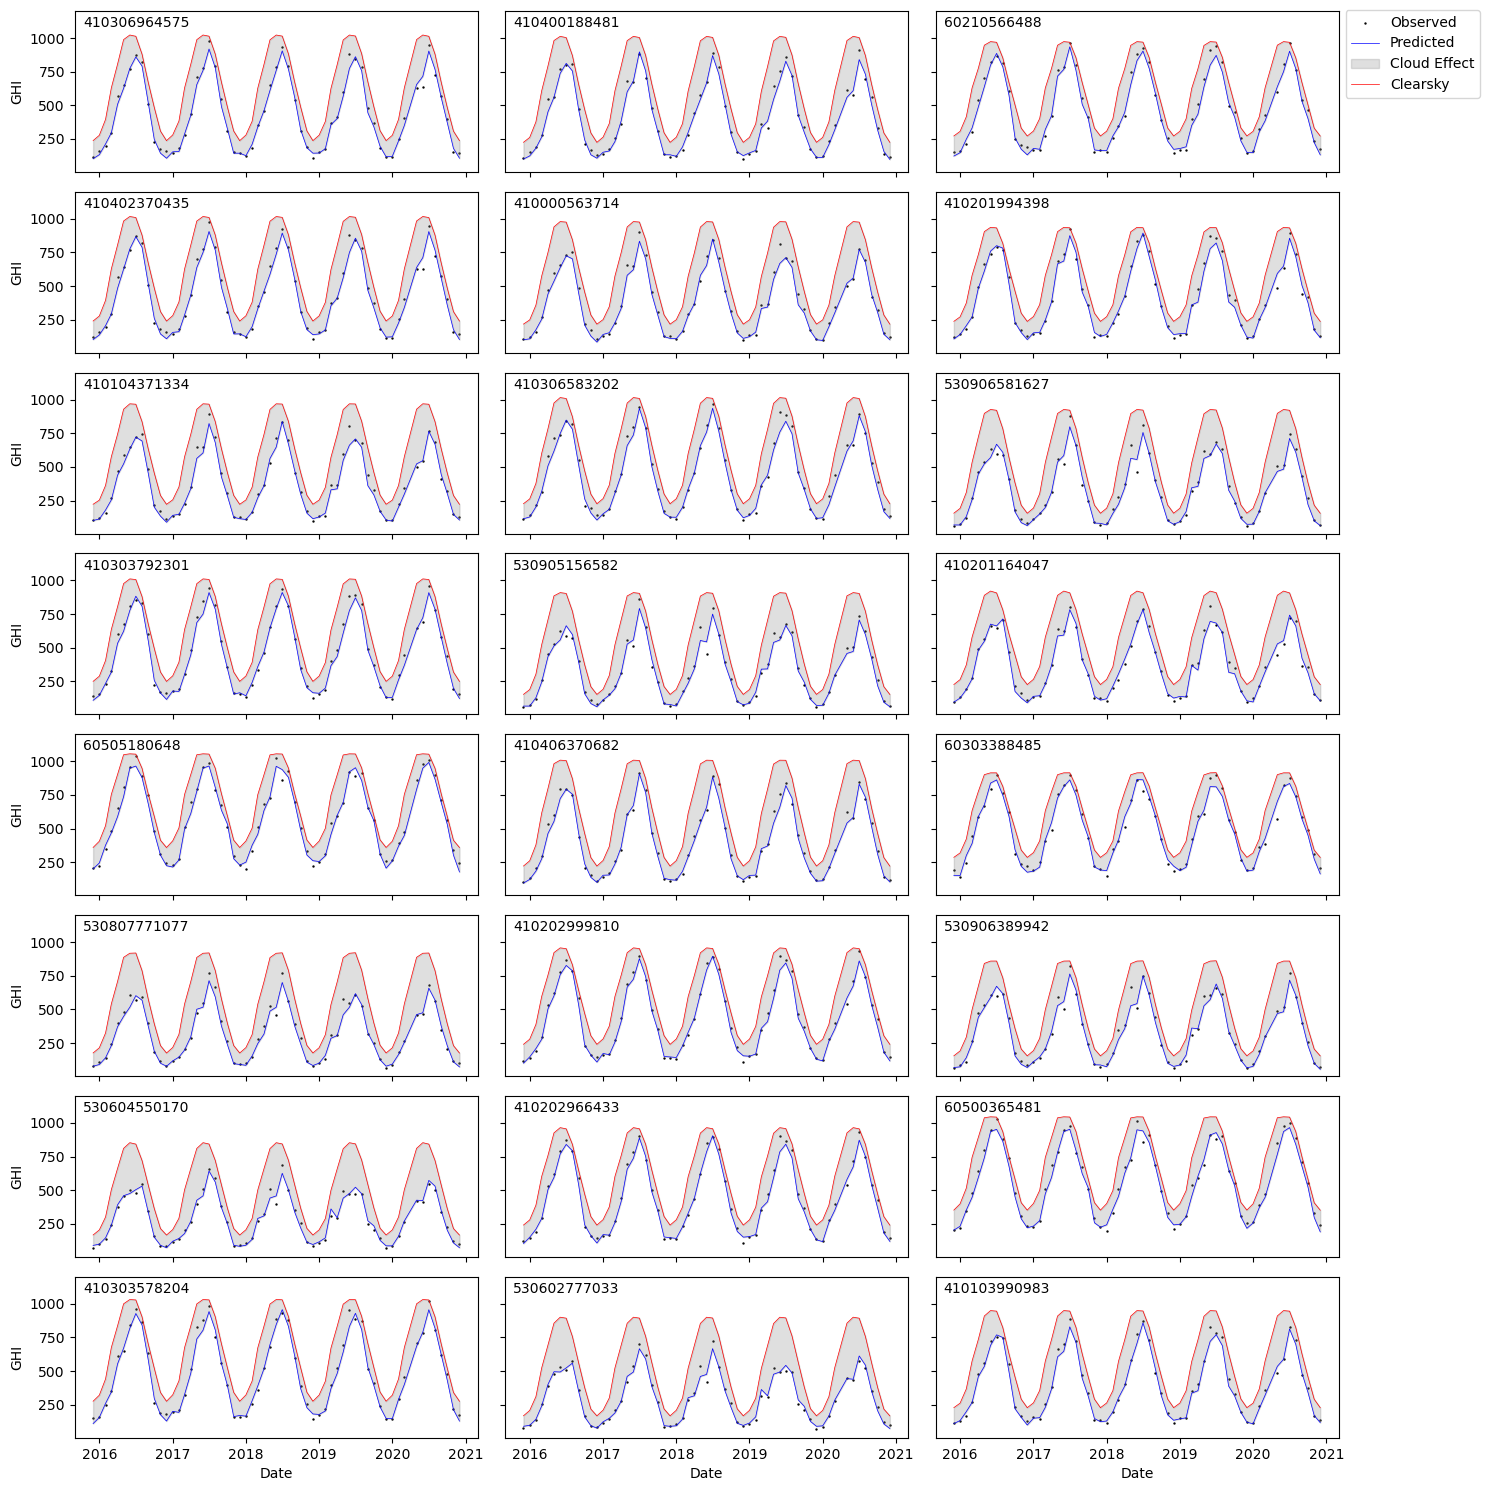

In [10]:
fig, axs = plt.subplots(8, 3, figsize=(15, 15), sharex=True, sharey=True)
plots = np.random.choice(obs.index.get_level_values(0), 24)
for i, plot in enumerate(plots):
    _, res = fit_linear_cloud(plot)
    coefs = res.x
    ghi_clear = obs.loc[plot, "CLEARSKY_GHI"]
    ghi_obs = cloud_cover_correction(ghi_clear.values, obs.loc[plot, "CLOUDS"].values)
    ghi_pred = pred_cloudy_ghi(
        coefs[:12],
        coefs[12],
        coefs[13],
        obs.loc[plot].index.month.values,
        obs.loc[plot, "RH"].values,
        locations.loc[plot, "ELEV"],
        obs.loc[plot, "CLEARSKY_GHI"].values,
    )
    dates = obs.loc[plot].index.to_timestamp()
    axs.ravel()[i].scatter(
        dates[-60:], ghi_obs[-60:], color="black", s=0.5, label="Observed"
    )
    axs.ravel()[i].plot(
        dates[-60:], ghi_pred[-60:], color="blue", lw=0.5, label="Predicted"
    )
    axs.ravel()[i].fill_between(
        dates[-60:],
        ghi_pred[-60:],
        ghi_clear.values[-60:],
        color="gray",
        alpha=0.25,
        label="Cloud Effect",
    )
    axs.ravel()[i].plot(
        dates[-60:], ghi_clear.values[-60:], color="red", lw=0.5, label="Clearsky"
    )
    axs.ravel()[i].text(0.02, 0.90, plot, transform=axs.ravel()[i].transAxes)

for ax in axs[-1, :]:
    ax.set_xlabel("Date")
for ax in axs[:, 0]:
    ax.set_ylabel("GHI")
    ax.set_ylim(None, 1200)
axs[0, -1].legend(bbox_to_anchor=(1.00, 1.05))

plt.tight_layout()
plt.savefig(
    "../reports/figures/observed_predicted_cloudy_ghi_timeseries.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

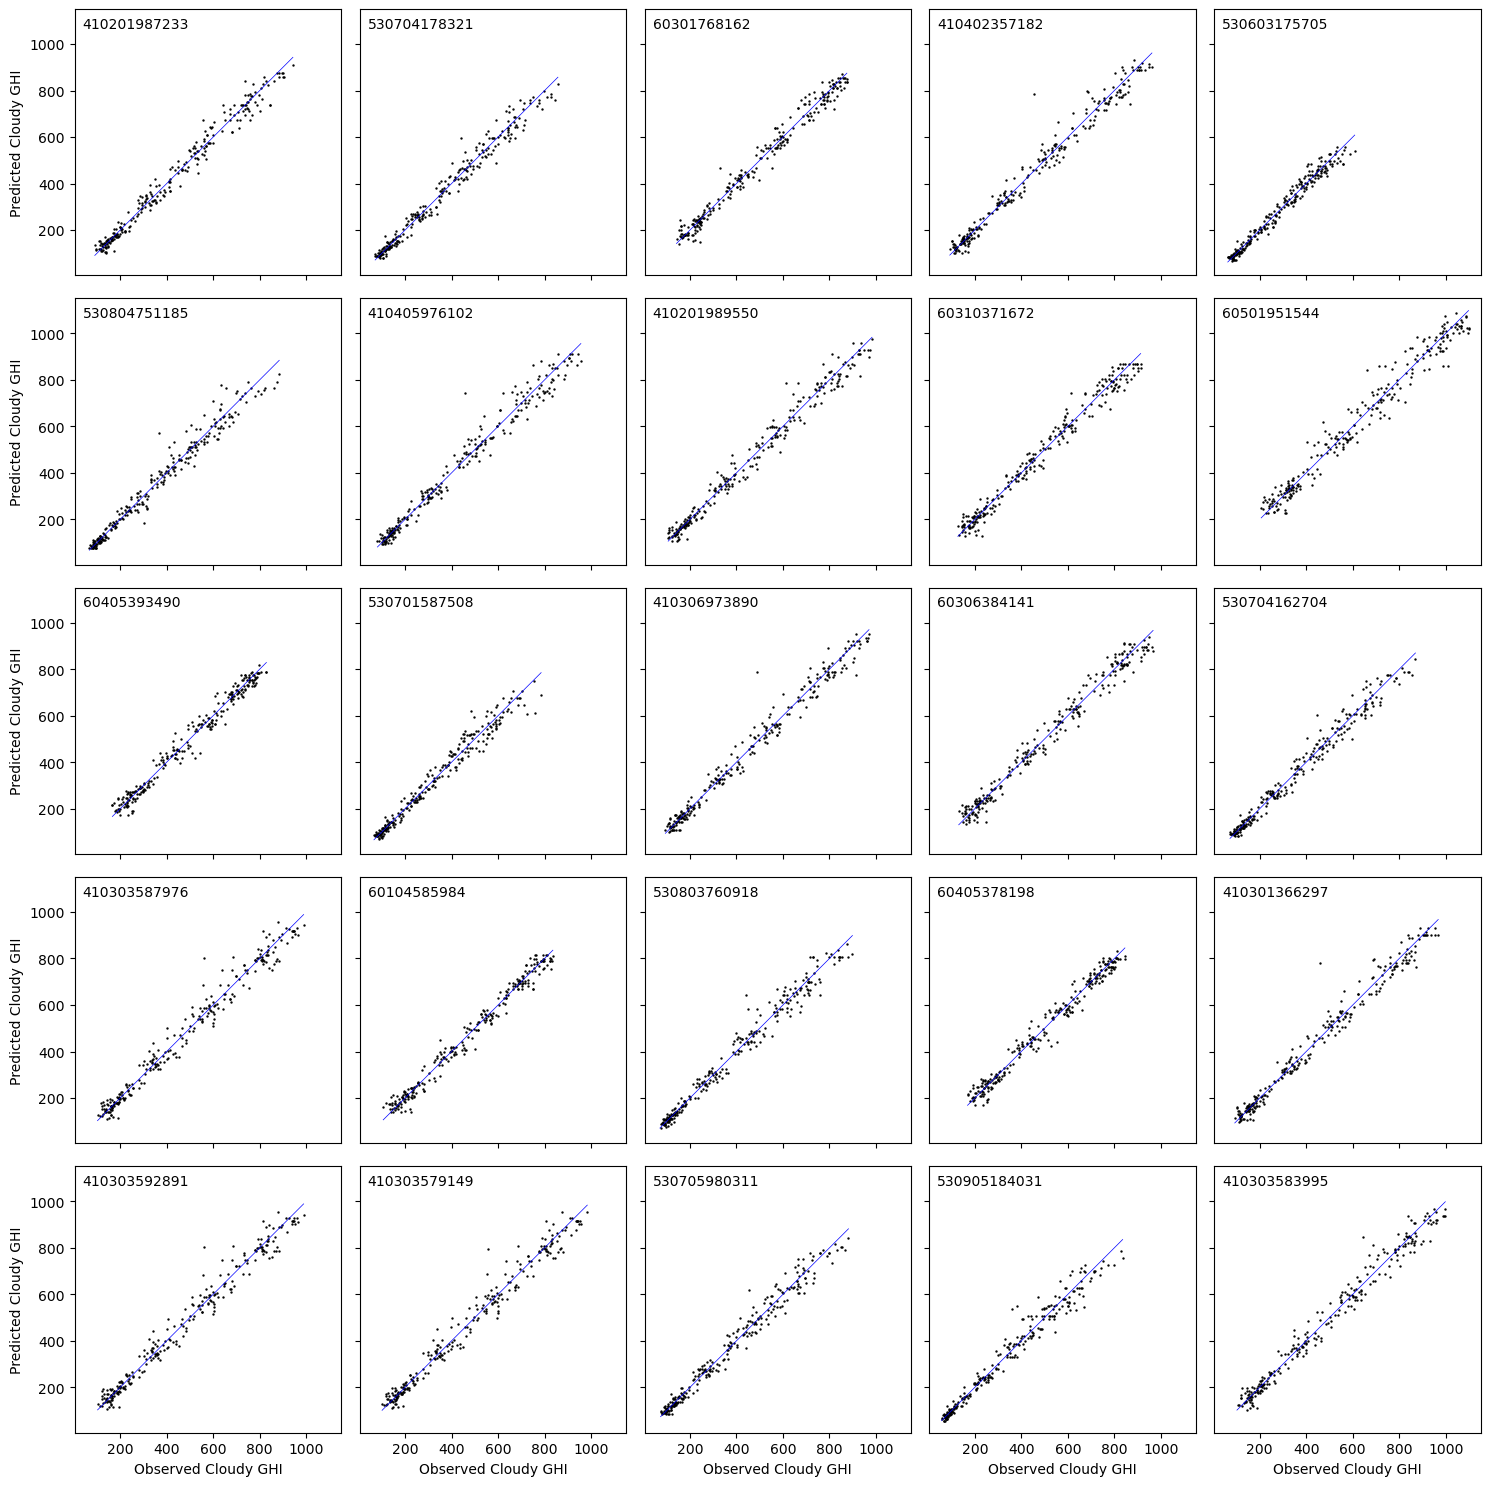

In [11]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15), sharex=True, sharey=True)
plots = np.random.choice(obs.index.get_level_values(0), 25)
for i, plot in enumerate(plots):
    _, res = fit_linear_cloud(plot)
    coefs = res.x
    x = cloud_cover_correction(
        obs.loc[plot, "CLEARSKY_GHI"].values, obs.loc[plot, "CLOUDS"].values
    )
    y = pred_cloudy_ghi(
        coefs[:12],
        coefs[12],
        coefs[13],
        obs.loc[plot].index.month.values,
        obs.loc[plot, "RH"].values,
        locations.loc[plot, "ELEV"],
        obs.loc[plot, "CLEARSKY_GHI"].values,
    )
    axs.ravel()[i].scatter(x, y, color="black", s=0.5)
    axs.ravel()[i].set_aspect("equal")
    minval = min(x.min(), y.min())
    maxval = max(x.max(), y.max())
    axs.ravel()[i].plot((minval, maxval), (minval, maxval), color="blue", lw=0.5)
    axs.ravel()[i].text(0.03, 0.93, plot, transform=axs.ravel()[i].transAxes)

for ax in axs[-1, :]:
    ax.set_xlabel("Observed Cloudy GHI")
for ax in axs[:, 0]:
    ax.set_ylabel("Predicted Cloudy GHI")

plt.tight_layout()
plt.savefig(
    "../reports/figures/observed_predicted_cloudy_ghi.png", dpi=300, bbox_inches="tight"
)
plt.show()

In [12]:
OVERWRITE = False
OUTFILE = "../data/interim/cloud_linear_coefs.csv"

plot_ids = pd.Series(
    np.unique(obs.index.get_level_values(0)), dtype=int, name="PLOT_ID"
)
COLS = [
    "JAN",
    "FEB",
    "MAR",
    "APR",
    "MAY",
    "JUN",
    "JUL",
    "AUG",
    "SEP",
    "OCT",
    "NOV",
    "DEC",
    "bRH",
    "bELEV",
]
if OVERWRITE or not os.path.exists(OUTFILE):
    results = pd.DataFrame(
        index=plot_ids, columns=COLS + ["RMSE", "ANNUAL_CLOUDY_GHI_PCT_DIFF"]
    )
else:
    results = pd.read_csv(OUTFILE).set_index("PLOT_ID")

to_run = results.loc[results.JAN.isna()].index
num_jobs = len(to_run)
with tqdm(total=num_jobs) as pbar:
    with ProcessPoolExecutor(40) as executor:
        jobs = [executor.submit(fit_linear_cloud, idx) for idx in to_run]
        for job in as_completed(jobs):
            idx, res = job.result()
            coefs = res.x
            observed = cloud_cover_correction(
                obs.loc[idx, "CLEARSKY_GHI"].values, obs.loc[idx, "CLOUDS"].values
            )
            predicted = pred_cloudy_ghi(
                coefs[:12],
                coefs[12],
                coefs[13],
                obs.loc[idx].index.month.values,
                obs.loc[idx, "RH"].values,
                locations.loc[idx, "ELEV"],
                obs.loc[idx, "CLEARSKY_GHI"].values,
                clip_clouds=True,
            )
            resid = observed - predicted
            rmse = np.sqrt((resid**2).mean())
            annual_diff_pct = (observed.sum() - predicted.sum()) / observed.sum()

            update = pd.Series(coefs, index=COLS)
            results.loc[idx, COLS] = update
            results.loc[idx, "RMSE"] = rmse
            results.loc[idx, "ANNUAL_CLOUDY_GHI_PCT_DIFF"] = annual_diff_pct
            pbar.update()

0it [00:00, ?it/s]

In [13]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12156 entries, 60101550679 to 530907572668
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   JAN                         12156 non-null  float64
 1   FEB                         12156 non-null  float64
 2   MAR                         12156 non-null  float64
 3   APR                         12156 non-null  float64
 4   MAY                         12156 non-null  float64
 5   JUN                         12156 non-null  float64
 6   JUL                         12156 non-null  float64
 7   AUG                         12156 non-null  float64
 8   SEP                         12156 non-null  float64
 9   OCT                         12156 non-null  float64
 10  NOV                         12156 non-null  float64
 11  DEC                         12156 non-null  float64
 12  bRH                         12156 non-null  float64
 13  bELEV         

In [14]:
results.to_csv(OUTFILE, index=True, header=True)

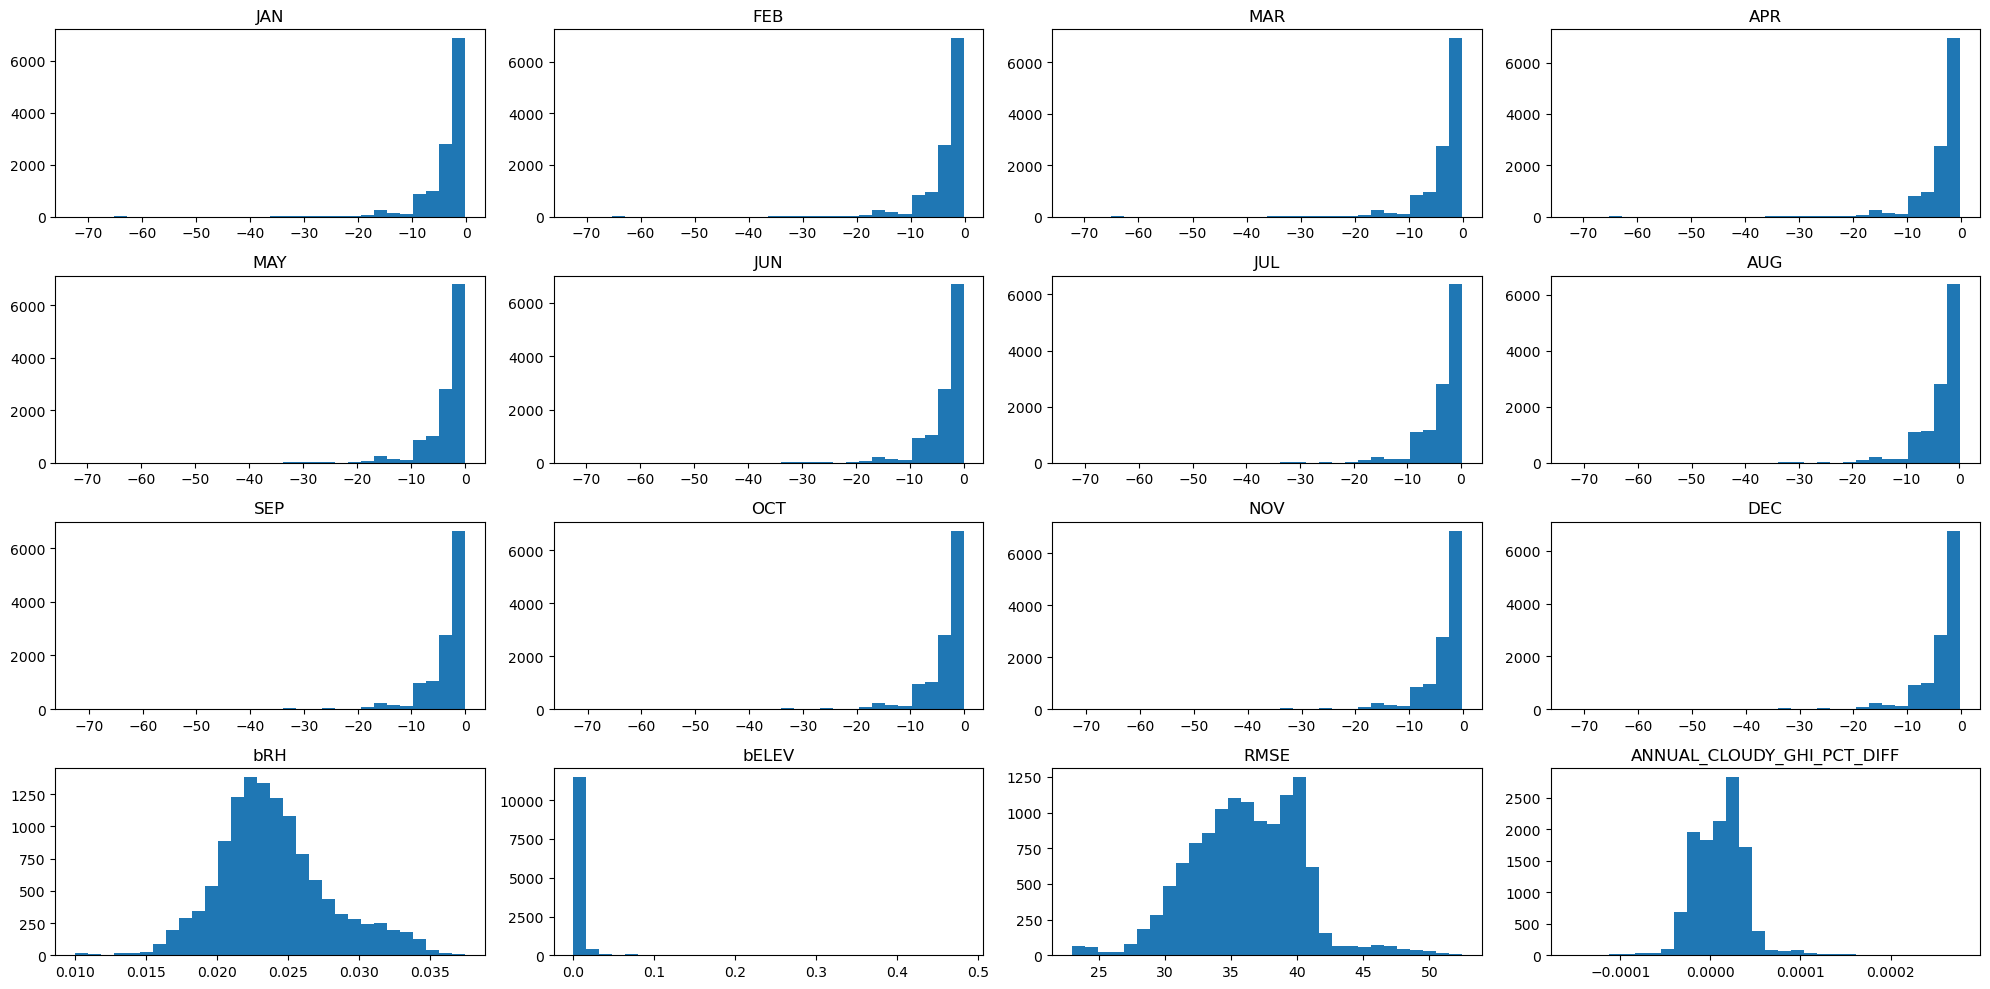

In [15]:
fig, axs = plt.subplots(4, 4, figsize=(20, 10))
for i, col in enumerate(results.columns):
    axs.ravel()[i].hist(results[col], bins=30)
    axs.ravel()[i].set_title(col)
plt.tight_layout()
plt.show()